#  P.S.V.S.AISHWARYA

#Importing the Libraries

In [33]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os

#Setting Random Seed

In [34]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In [35]:
#Reading Train.csv and Test.csv

In [17]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 8 #experiment with the batch size

#Setting the image_height and image_width

In [36]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 100
image_width = 100
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int) #create a list of image numbers you want to use for a particular video

#Resizing the Image

In [19]:
from skimage.io import imread
from skimage.transform import resize

def resize_crop_image(image):
    if image.shape[0] > 120 and image.shape[1] > 120:
        image = resize(image, (120, 120))
        
    height = image.shape[0]
    width = image.shape[1]
    height_center = height//2
    width_center = width//2
    image = image[(height_center-60):(height_center+70), (width_center-50):(width_center+70)]
    image = resize(image,(image_height, image_width))
    return image

#Image Plotting Code

In [20]:
from matplotlib import pyplot as plt

def show_resize_crop_image(paths):

    for index, path in enumerate(paths):
        plt.figure(figsize=(20,20))
            
        plt.subplot(5, 2, index*2+1)
        image = resize_crop_image(imread(path))
        plt.imshow(image)
        plt.title('Modified')
        
        plt.subplot(5, 2, index*2+2)
        plt.imshow(imread(path))
        plt.title('Original')
                
    plt.show()

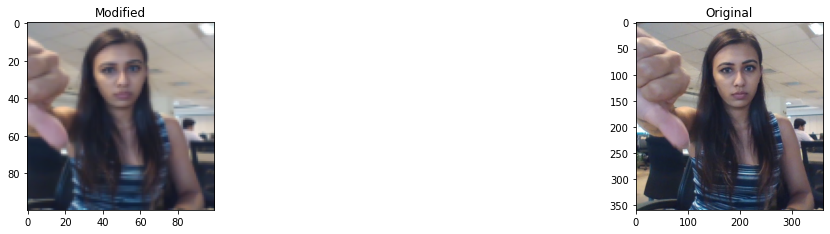

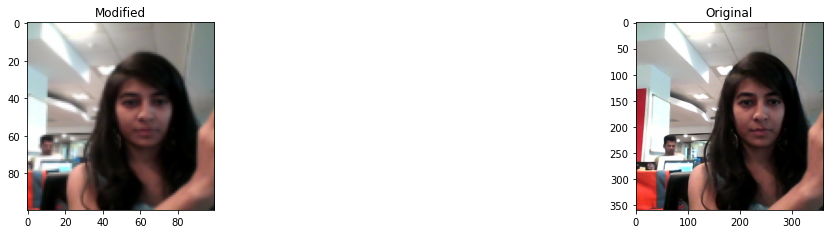

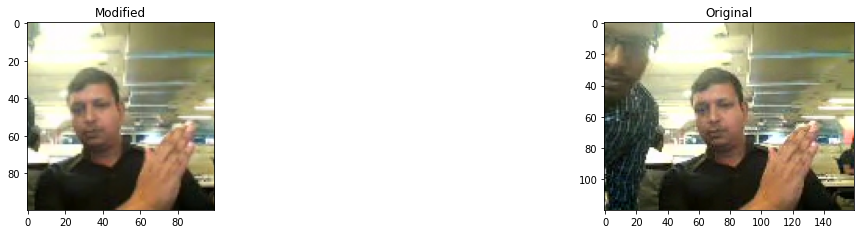

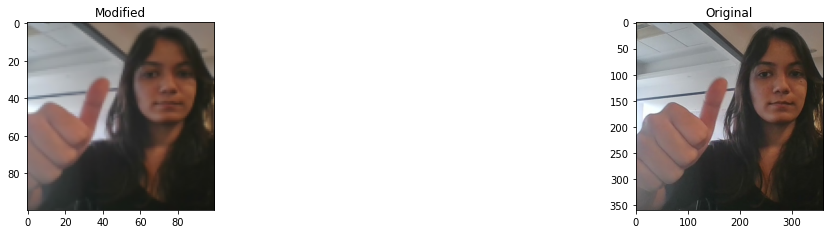

In [21]:
paths = ["/home/datasets/Project_data/train/WIN_20180907_15_53_00_Pro_Thumbs Down_new/WIN_20180907_15_53_00_Pro_00001.png",
        "/home/datasets/Project_data/train/WIN_20180907_15_56_38_Pro_Right Swipe_new/WIN_20180907_15_56_38_Pro_00013.png",
        "/home/datasets/Project_data/train/WIN_20180925_17_22_32_Pro_Right_Swipe_new/WIN_20180925_17_22_32_Pro_00009.png",
        "/home/datasets/Project_data/train/WIN_20180907_15_53_12_Pro_Thumbs Up_new/WIN_20180907_15_53_12_Pro_00011.png"]

show_resize_crop_image(paths)

#Generator Code

In [26]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, len(img_idx), image_height, image_width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, gestures)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize_crop_image(image)
                                         
                    batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size * num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            
            for batch in range(batch_size): # we iterate over the number of batches
                batch_data = np.zeros((batch_size, len(img_idx), image_height, image_width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_labels = np.zeros((batch_size, gestures)) # batch_labels is the one hot representation of the output
                for folder in range(batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                        #crop the images and resize them. Note that the images are of 2 different shape 
                        #and the conv3D will throw error if the inputs in a batch have different shapes
                        image = resize_crop_image(image)
                                         
                        batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                        batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                        batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image
                    
                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [23]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 25


MODEL WITH CONV3D

In [24]:
#Using image_height as 50 , image_width as 50 ,gestures As 5,total_frames As 30,num_frames As 10
num_frames = 10
total_frames = 30
num_frames = 10
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4

num_epochs=35

MODEL BUILDING

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 10, 50, 50, 8)     656       
                                                                 
 batch_normalization_9 (Batc  (None, 10, 50, 50, 8)    32        
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 10, 50, 50, 8)     0         
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 5, 25, 25, 8)     0         
 3D)                                                             
                                                                 
 conv3d_10 (Conv3D)          (None, 5, 25, 25, 16)     3472      
                                                                 
 batch_normalization_10 (Bat  (None, 5, 25, 25, 16)   

In [28]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [29]:
model_name = 'model_exp8_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [30]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

FITTING MODEL

In [31]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 4
Epoch 1/35
166/166 [==============================] - ETA: 0s - loss: 1.8199 - categorical_accuracy: 0.2685Source path =  /home/datasets/Project_data/val ; batch size = 4

Epoch 00001: val_loss improved from inf to 1.44814, saving model to model_exp8_2023-02-1415_16_12.243256/model-00001-1.81991-0.26848-1.44814-0.34000.h5
166/166 [==============================] - 92s 553ms/step - loss: 1.8199 - categorical_accuracy: 0.2685 - val_loss: 1.4481 - val_categorical_accuracy: 0.3400 - lr: 2.0000e-04
Epoch 2/35
166/166 [==============================] - ETA: 0s - loss: 1.5140 - categorical_accuracy: 0.3353
Epoch 00002: val_loss improved from 1.44814 to 1.23788, saving model to model_exp8_2023-02-1415_16_12.243256/model-00002-1.51395-0.33534-1.23788-0.47000.h5
166/166 [==============================] - 72s 432ms/step - loss: 1.5140 - categorical_accuracy: 0.3353 - val_loss: 1.2379 - val_categorical_accuracy: 0.4700 - lr: 2.0000e

PLOTTING THE MODEL OF COV3D

**Training Accuracy:** 0.9%

**Validation Accuracy:** 0.8%

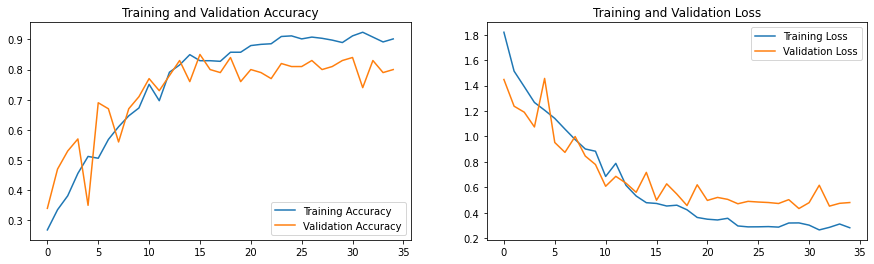

In [32]:
from IPython.display import Markdown, display

def plot_history(history):
    display(Markdown("**Training Accuracy:** " + str(round(history.history['categorical_accuracy'][num_epochs-1], 2)) + "%"))
    display(Markdown("**Validation Accuracy:** " + str(round(history.history['val_categorical_accuracy'][num_epochs-1], 2)) + "%"))
    
    #print("Training Accuracy:" + history.history['categorical_accuracy'][num_epochs-1])
    #print("Validation Accuracy:" + history.history['val_categorical_accuracy'][num_epochs-1])

    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history)


ACCURACY OF COV3D IS 0.9 % FOR TRAINING AND 0.8% VALIDATION ACCURACY
->After Trail and error finally after using epoch size of 35 , batch size as 4 ,img_width as 50 and img_height as 50 got validation accuracy as 80% and training accuracy 90%

MODEL WITH TIMEDISTRIBUTED AND CONV2D

In [39]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout,LSTM,Conv3D,Conv2D, MaxPooling3D,MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import optimizers
from keras.layers import Dropout

In [48]:
train_generator = generator(train_path, train_doc, 30)
val_generator = generator(val_path, val_doc, 30)

BUILDING MODEL WITH TIMEDISTRIBUTED AND CONV2D

In [40]:
#write your model here
nb_featuremap = [8,16,32,64]
nb_dense = [128,64,5]
nb_classes = 5
rows = 120   # X 
cols = 120   # Y 
channel = 3  # number of channels in images 3 for color(RGB)
frames=15
batch_size = 10
#model = Sequential()
model1 = Sequential()
model1.add(TimeDistributed(Conv2D(nb_featuremap[0], (3, 3),activation='relu', padding='same'), input_shape=(len(img_idx), image_height, image_width, 3)))


#model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))

model1.add(TimeDistributed(Conv2D(nb_featuremap[1], (3,3),padding='same', activation='relu')))
model1.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model1.add(TimeDistributed(Conv2D(nb_featuremap[2], (3,3),padding='same', activation='relu')))
model1.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model1.add(TimeDistributed(Conv2D(nb_featuremap[3], (2,2),padding='same', activation='relu')))
model1.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model1.add(TimeDistributed(BatchNormalization()))
model1.add(Dropout(0.25))

model1.add(Flatten())

model1.add(Dense(nb_dense[0], activation='relu'))
model1.add(Dropout(0.25))
model1.add(Dense(nb_dense[1], activation='relu'))
model1.add(Dropout(0.25))

## using GRU as the RNN model along with softmax as our last layer.
#model.add(GRU(128, return_sequences=False))
model1.add(Dense(nb_classes, activation='softmax')) # using Softmax as last layer
optimiser = optimizers.Adam(learning_rate=0.0001)
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model1.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 100, 100, 8)  224       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 100, 100, 16)  1168     
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 50, 50, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 50, 50, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 15, 25, 25, 32)  

In [14]:
model_name1 = 'model_exp1_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name1):
    os.mkdir(model_name1)
        
filepath = model_name1 + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list1 = [checkpoint, LR]

FITTING THE MODEL

In [20]:
history1 = model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=15, verbose=1, 
                    callbacks=callbacks_list1, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/15
166/166 [==============================] - ETA: 0s - loss: 1.6448 - categorical_accuracy: 0.3690Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: val_loss improved from inf to 1.70860, saving model to model_exp1_2023-02-1214_27_23.083021/model-00001-1.64482-0.36905-1.70860-0.39355.h5
166/166 [==============================] - 191s 1s/step - loss: 1.6448 - categorical_accuracy: 0.3690 - val_loss: 1.7086 - val_categorical_accuracy: 0.3935 - lr: 1.0000e-04
Epoch 2/15
166/166 [==============================] - ETA: 0s - loss: 1.2751 - categorical_accuracy: 0.5060
Epoch 00002: val_loss improved from 1.70860 to 1.28521, saving model to model_exp1_2023-02-1214_27_23.083021/model-00002-1.27511-0.50602-1.28521-0.51200.h5
166/166 [==============================] - 80s 485ms/step - loss: 1.2751 - categorical_accuracy: 0.5060 - val_loss: 1.2852 - val_categorical_accuracy: 0.5120 - lr: 1.0000e

**Training Accuracy:** 0.92%

**Validation Accuracy:** 0.69%

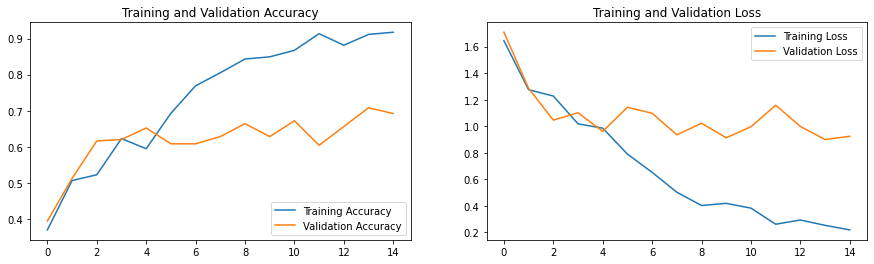

In [32]:
from IPython.display import Markdown, display

def plot_history(history):
    display(Markdown("**Training Accuracy:** " + str(round(history.history['categorical_accuracy'][15-1], 2)) + "%"))
    display(Markdown("**Validation Accuracy:** " + str(round(history.history['val_categorical_accuracy'][15-1], 2)) + "%"))
    
    #print("Training Accuracy:" + history.history['categorical_accuracy'][num_epochs-1])
    #print("Validation Accuracy:" + history.history['val_categorical_accuracy'][num_epochs-1])
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(15)

    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

  
plot_history(history1)

GETTING TRAINING ACCURACY 0.92% AND VALIDATION ACCURACY 0.69%

BUILDING MODEL WITH TIMEDISTRIBUTED AND CONV2D WITH GRU

In [37]:
batch_size = 30

In [12]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout,LSTM,Conv3D,Conv2D, MaxPooling3D,MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import optimizers
from keras.layers import Dropout

In [13]:
train_generator = generator(train_path, train_doc, 6)
val_generator = generator(val_path, val_doc, 6)

BUILDING THE MODEL

In [29]:
#write your model here
nb_featuremap = [8,16,32,64]
nb_dense = [128,64,5]
nb_classes = 5
rows = 120   # X 
cols = 120   # Y 
channel = 3  # number of channels in images 3 for color(RGB)
frames=15
# Input
#input_shape=(frames,rows,cols,channel)
batch_size = 10
#model = Sequential()
model23 = Sequential()
model23.add(TimeDistributed(Conv2D(nb_featuremap[0], (3, 3),activation='relu', padding='same'), input_shape=(len(img_idx), image_height, image_width, 3)))


#model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))

model23.add(TimeDistributed(Conv2D(nb_featuremap[1], (3,3),padding='same', activation='relu')))
model23.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model23.add(TimeDistributed(Conv2D(nb_featuremap[2], (3,3),padding='same', activation='relu')))
model23.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model23.add(TimeDistributed(Conv2D(nb_featuremap[3], (2,2),padding='same', activation='relu')))
model23.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model23.add(TimeDistributed(BatchNormalization()))
model23.add(Dropout(0.25))

model23.add(TimeDistributed(Flatten()))

model23.add(Dense(nb_dense[0], activation='relu'))
model23.add(Dropout(0.25))
model23.add(Dense(nb_dense[1], activation='relu'))
model23.add(Dropout(0.25))

## using GRU as the RNN model along with softmax as our last layer.
model23.add(GRU(128, return_sequences=False))
model23.add(Dense(nb_classes, activation='softmax')) # using Softmax as last layer
optimiser = optimizers.Adam(learning_rate=0.0001)
model23.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model23.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_27 (TimeDi  (None, 10, 50, 50, 8)    224       
 stributed)                                                      
                                                                 
 time_distributed_28 (TimeDi  (None, 10, 50, 50, 16)   1168      
 stributed)                                                      
                                                                 
 time_distributed_29 (TimeDi  (None, 10, 25, 25, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_30 (TimeDi  (None, 10, 25, 25, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_31 (TimeDi  (None, 10, 12, 12, 32)  

In [30]:
model_name23 = 'model_exp1_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name23):
    os.mkdir(model_name23)
        
filepath = model_name23 + 'model_GRU-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list3= [checkpoint, LR]

FITTING THE MODEL

In [31]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/6)
else:
    steps_per_epoch = (num_train_sequences//6) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/6)
else:
    validation_steps = (num_val_sequences//6) + 1
history23 = model23.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list3, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 6
Epoch 1/20
111/111 [==============================] - ETA: 0s - loss: 1.5603 - categorical_accuracy: 0.2866Source path =  /home/datasets/Project_data/val ; batch size = 6

Epoch 00001: val_loss improved from inf to 1.83112, saving model to model_exp1_2023-02-1305_06_54.426715/model_GRU-00001-1.56028-0.28658-1.83112-0.28125.h5
111/111 [==============================] - 76s 671ms/step - loss: 1.5603 - categorical_accuracy: 0.2866 - val_loss: 1.8311 - val_categorical_accuracy: 0.2812 - lr: 1.0000e-04
Epoch 2/20
111/111 [==============================] - ETA: 0s - loss: 1.3346 - categorical_accuracy: 0.4084
Epoch 00002: val_loss improved from 1.83112 to 1.45687, saving model to model_exp1_2023-02-1305_06_54.426715/model_GRU-00002-1.33455-0.40841-1.45687-0.39062.h5
111/111 [==============================] - 38s 342ms/step - loss: 1.3346 - categorical_accuracy: 0.4084 - val_loss: 1.4569 - val_categorical_accuracy: 0.3906 - lr:

PLOTTING THE GRAPH

**Training Accuracy:** 0.89%

**Validation Accuracy:** 0.7%

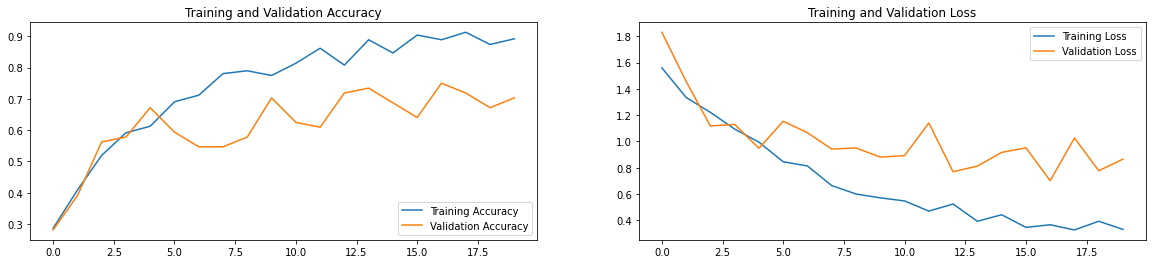

In [35]:
from IPython.display import Markdown, display

def plot_history(history):
    display(Markdown("**Training Accuracy:** " + str(round(history.history['categorical_accuracy'][20-1], 2)) + "%"))
    display(Markdown("**Validation Accuracy:** " + str(round(history.history['val_categorical_accuracy'][20-1], 2)) + "%"))
    
    #print("Training Accuracy:" + history.history['categorical_accuracy'][num_epochs-1])
    #print("Validation Accuracy:" + history.history['val_categorical_accuracy'][num_epochs-1])
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(20)

    plt.figure(figsize=(20, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

  
plot_history(history23)

GETTING THE TRAINING  ACCURACY OF 0.89% AND VALIDATION ACCURACY 0.7%

TRANSFER LEARNING WITH RESNET50

In [49]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
#write your model here
nb_featuremap = [8,16,32,64]
nb_dense = [128,64,5]
nb_classes = 5
rows = 120   # X 
cols = 120   # Y 
channel = 3  # number of channels in images 3 for color(RGB)
frames=15
# Input
#input_shape=(frames,rows,)

resnet =ResNet50(weights='imagenet', include_top=False)
for layer in resnet.layers:
    layer.trainable=False

model1 = Sequential([TimeDistributed(resnet,input_shape=(len(img_idx), image_height, image_width, 3))])
model1.add(TimeDistributed(Conv2D(nb_featuremap[0], (3, 3),activation='relu', padding='same'), input_shape=(len(img_idx), image_height, image_width, 3)))



#model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))



model1.add(TimeDistributed(BatchNormalization()))
model1.add(TimeDistributed(MaxPooling2D((2, 2))))
model1.add(Dropout(0.25))

model1.add(TimeDistributed(Flatten()))

#model1.add(Dense(nb_dense[0], activation='relu'))
#model1.add(Dense(nb_dense[1], activation='relu'))
#model1.add(Dropout(0.25))

## using GRU as the RNN model along with softmax as our last layer.
model1.add(LSTM(64))
model1.add(Dense(nb_classes, activation='softmax')) # using Softmax as last layer
optimiser = optimizers.Adam(learning_rate=0.0002)
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [50]:
train_generator = generator(train_path, train_doc, 4)
val_generator = generator(val_path, val_doc, 4)

In [51]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/4)
else:
    steps_per_epoch = (num_train_sequences//4) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/4)
else:
    validation_steps = (num_val_sequences//4) + 1
history23_transferlearning = model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=15, verbose=1, 
                     validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 4
Epoch 1/15
166/166 [==============================] - 224s 814ms/step - loss: 1.4533 - categorical_accuracy: 0.3786 - val_loss: 1.2217 - val_categorical_accuracy: 0.5600
Epoch 2/15
166/166 [==============================] - 106s 643ms/step - loss: 1.1648 - categorical_accuracy: 0.5904 - val_loss: 1.2689 - val_categorical_accuracy: 0.4400
Epoch 3/15
166/166 [==============================] - 105s 636ms/step - loss: 1.0343 - categorical_accuracy: 0.6546 - val_loss: 1.0764 - val_categorical_accuracy: 0.6100
Epoch 4/15
166/166 [==============================] - 106s 637ms/step - loss: 0.9127 - categorical_accuracy: 0.6647 - val_loss: 0.9279 - val_categorical_accuracy: 0.6400
Epoch 5/15
166/166 [==============================] - 106s 641ms/step - loss: 0.7260 - categorical_accuracy: 0.7510 - val_loss: 1.1372 - val_categorical_accuracy: 0.5500
Epoch 6/15
166/166 [==============================] - 105s 636ms/step - loss: 0.6541

**Training Accuracy:** 0.93%

**Validation Accuracy:** 0.7%

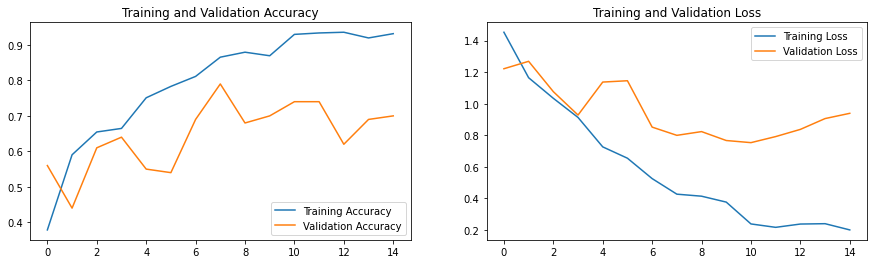

In [53]:
from IPython.display import Markdown, display

def plot_history(history):
    display(Markdown("**Training Accuracy:** " + str(round(history.history['categorical_accuracy'][15-1], 2)) + "%"))
    display(Markdown("**Validation Accuracy:** " + str(round(history.history['val_categorical_accuracy'][15-1], 2)) + "%"))
    
    #print("Training Accuracy:" + history.history['categorical_accuracy'][num_epochs-1])
    #print("Validation Accuracy:" + history.history['val_categorical_accuracy'][num_epochs-1])
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(15)

    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

  
plot_history(history23_transferlearning)

    GETTING TRAINING ACCURACY OF 0.93% nd VALIDATION ACCURACY 0.7%

CONCLUSION

FROM THE ABOVE ANALYSIS WILL CHOOSE THE CONV3D AS THE FINAL MODEL COZ IT IS GIVING VALIDATION ACCURACY AS 80%